In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import  train_test_split 
import math
from tensorflow.keras.utils import to_categorical
import os
import cv2

C:\Users\Bjorn\anaconda3\envs\new_tf\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Bjorn\anaconda3\envs\new_tf\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
cat_path = "datasett-hundogkatt/training_set/training_set/cats/"
dog_path = "datasett-hundogkatt/training_set/training_set/dogs/"

In [3]:
cat_img = []
for i in os.listdir(cat_path):
    if i.endswith(".jpg"):
        temp_img = cv2.imread(os.path.join(cat_path, i), cv2.IMREAD_COLOR)[:,:,::-1]
        temp_img = cv2.resize(temp_img, (64,64), interpolation= cv2.INTER_LINEAR )
        cat_img.append(temp_img)

In [4]:
cat_img = np.asarray(cat_img)

In [5]:
y_cat = np.zeros(cat_img.shape[0])

In [6]:
dog_img = []
for i in os.listdir(dog_path):
    if i.endswith(".jpg"):
        temp_img = cv2.imread(os.path.join(dog_path, i), cv2.IMREAD_COLOR)[:,:,::-1]
        temp_img = cv2.resize(temp_img, (64,64), interpolation= cv2.INTER_LINEAR )
        dog_img.append(temp_img)

In [7]:
dog_img = np.asarray(dog_img)

In [8]:
y_dog = np.ones(dog_img.shape[0])

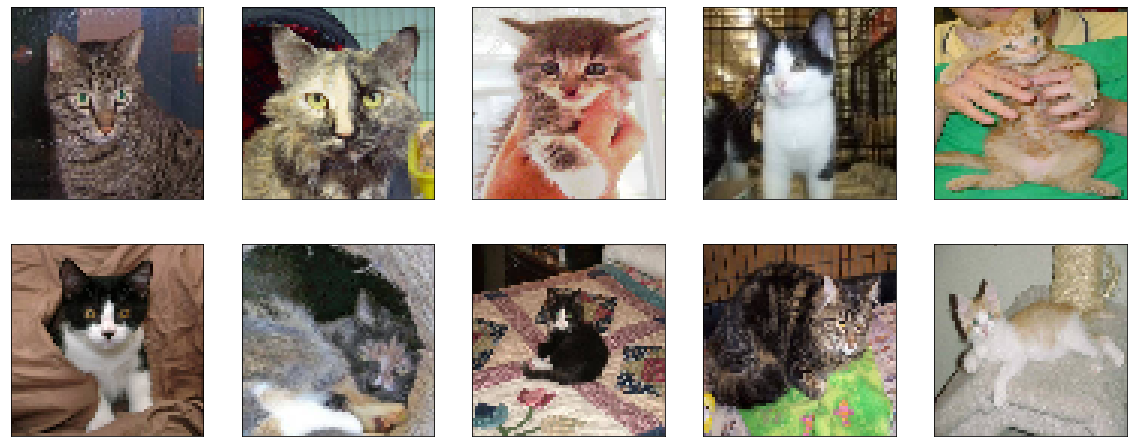

In [9]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(cat_img[i])
    plt.xticks([])
    plt.yticks([])
plt.savefig("cat_images.png",dpi=100)

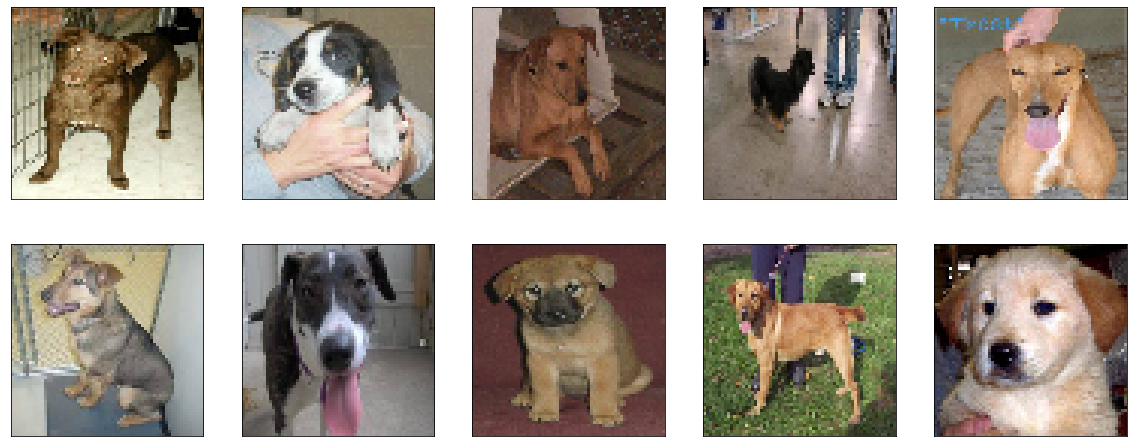

In [10]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(dog_img[i])
    plt.xticks([])
    plt.yticks([])
plt.savefig("dog_images.png",dpi=100)

In [11]:
X = np.vstack([cat_img,dog_img])

In [12]:
y = np.hstack([y_cat,y_dog])

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)

In [14]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([3180, 3224], dtype=int64))

In [15]:
np.unique(y_val, return_counts=True)

(array([0., 1.]), array([820, 781], dtype=int64))

In [16]:
y_train = np.expand_dims(y_train ,-1)

In [17]:
X_train.shape

(6404, 64, 64, 3)

In [18]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    classes=1,
    classifier_activation="softmax",
    input_shape=(64, 64, 3)
)

In [19]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [20]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
pred = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs = base_model.input, outputs = pred)

In [21]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(curve='ROC')])

In [22]:
history = model.fit(x=X_train,y=y_train, epochs=25, batch_size=64, validation_data=(X_val,y_val), shuffle=True)

Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 78s 349ms/step - auc: 0.5749 - binary_accuracy: 0.5415 - loss: 0.6924 - val_auc: 0.7247 - val_binary_accuracy: 0.6227 - val_loss: 0.6389
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - auc: 0.7444 - binary_accuracy: 0.6633 - loss: 0.6247 - val_auc: 0.8236 - val_binary_accuracy: 0.7339 - val_loss: 0.5841
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - auc: 0.8322 - binary_accuracy: 0.7460 - loss: 0.5757 - val_auc: 0.8705 - val_binary_accuracy: 0.7908 - val_loss: 0.5411
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - auc: 0.8751 - binary_accuracy: 0.7909 - loss: 0.5344 - val_auc: 0.8947 - val_binary_accuracy: 0.8151 - val_loss: 0.5054
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - auc: 0.8857 - binary_accuracy: 0.8035 - loss: 0.5078 - val_auc: 0.9088 - val_binary_accuracy: 0.8332 - val_loss: 0.4751
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - auc: 0.9076 - binary_accuracy: 0.8224 - loss: 0.4746 - val

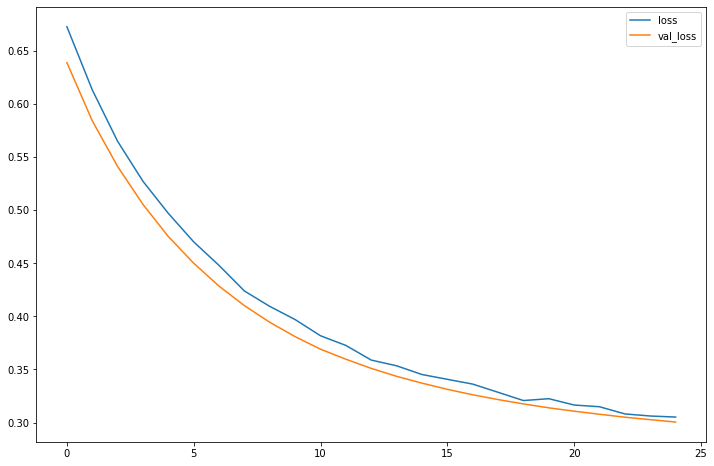

In [23]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

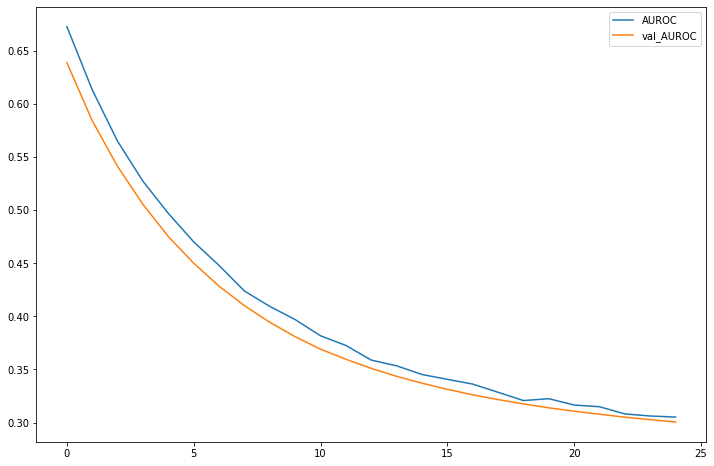

In [24]:
plt.figure(figsize=(12,8))
plt.plot(history.history[list(history.history.keys())[2]], label="AUROC")
plt.plot(history.history[list(history.history.keys())[5]], label="val_AUROC")
plt.legend()